In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate

# Load CIFAR-10 and resize to 64x64
(x_train, _), (x_test, _) = tf.keras.datasets.cifar10.load_data()
x_train = tf.image.resize(x_train, (64, 64)).numpy() / 255.0
x_test = tf.image.resize(x_test, (64, 64)).numpy() / 255.0

# Add Gaussian noise to training & testing images
def add_gaussian_noise(x):
    noise = np.random.normal(loc=0.0, scale=0.1, size=x.shape)
    x_noisy = np.clip(x + noise, 0.0, 1.0)
    return x_noisy

x_train_noisy = add_gaussian_noise(x_train)
x_test_noisy = add_gaussian_noise(x_test)

# Load VGG16 for perceptual loss (freeze weights)
vgg = VGG16(include_top=False, weights='imagenet', input_shape=(64, 64, 3))
vgg.trainable = False
vgg_model = Model(inputs=vgg.input, outputs=vgg.get_layer('block3_conv3').output)

# Normalize for VGG input
def preprocess_vgg(x):
    return tf.keras.applications.vgg16.preprocess_input(x * 255.0)

# Define perceptual loss using VGG16 features
def perceptual_loss(y_true, y_pred):
    y_true_pp = preprocess_vgg(y_true)
    y_pred_pp = preprocess_vgg(y_pred)
    true_features = vgg_model(y_true_pp)
    pred_features = vgg_model(y_pred_pp)
    return tf.reduce_mean(tf.square(true_features - pred_features))

# Define simple U-Net Autoencoder
def build_simple_unet_autoencoder(input_shape=(64, 64, 3)):
    inputs = Input(shape=input_shape)

    # Encoder
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    p2 = MaxPooling2D((2, 2))(c2)

    # Bottleneck
    b = Conv2D(128, (3, 3), activation='relu', padding='same')(p2)

    # Decoder
    u1 = UpSampling2D((2, 2))(b)
    u1 = Concatenate()([u1, c2])
    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(u1)

    u2 = UpSampling2D((2, 2))(c3)
    u2 = Concatenate()([u2, c1])
    c4 = Conv2D(32, (3, 3), activation='relu', padding='same')(u2)

    outputs = Conv2D(3, (1, 1), activation='sigmoid')(c4)

    model = Model(inputs, outputs)
    return model

# Build and compile autoencoder
autoencoder = build_simple_unet_autoencoder()
autoencoder.compile(optimizer='adam', loss=perceptual_loss)
autoencoder.summary()

# Train the model
history = autoencoder.fit(
    x_train_noisy, x_train,
    epochs=10,
    batch_size=32,
    shuffle=True,
    validation_data=(x_test_noisy, x_test)
)

# Predict on test noisy images
decoded_imgs = autoencoder.predict(x_test_noisy[:10])




Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 64,    │        896 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 32, 32,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 16, 16,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 16, 16,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 32, 32,    │          0 │ conv2d_2[0][0]    │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 192)              │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 32,    │    110,656 │ concatenate[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 64, 64,    │          0 │ up_sampling2d_1[… │
│ (Concatenate)       │ 96)               │            │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     27,680 │ concatenate_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64, 3) │         99 │ conv2d_4[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 231,683 (905.01 KB)

 Trainable params: 231,683 (905.01 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 898s 572ms/step - loss: 44377.6250 - val_loss: 27906.3672
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 877s 561ms/step - loss: 26760.2363 - val_loss: 25512.3691
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 857s 549ms/step - loss: 25147.9512 - val_loss: 24641.7793
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 832s 532ms/step - loss: 24400.6680 - val_loss: 24290.3457
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 713s 456ms/step - loss: 24031.8965 - val_loss: 23794.1191
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 745s 458ms/step - loss: 23661.6250 - val_loss: 23994.2520
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 709s 454ms/step - loss: 23456.1895 - val_loss: 23495.6777
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 789s 505ms/step - loss: 23269.9297 - val_loss: 23324.5176
Epoch 9/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 814s 521ms/step - loss: 23136.9512 - val_loss: 23043.7598
Epoch 10/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 723s 462ms/step - loss: 23009.2949 - val_loss: 22916.8496

NameError: name 'plt' is not defined

In [3]:
import matplotlib.pyplot as plt


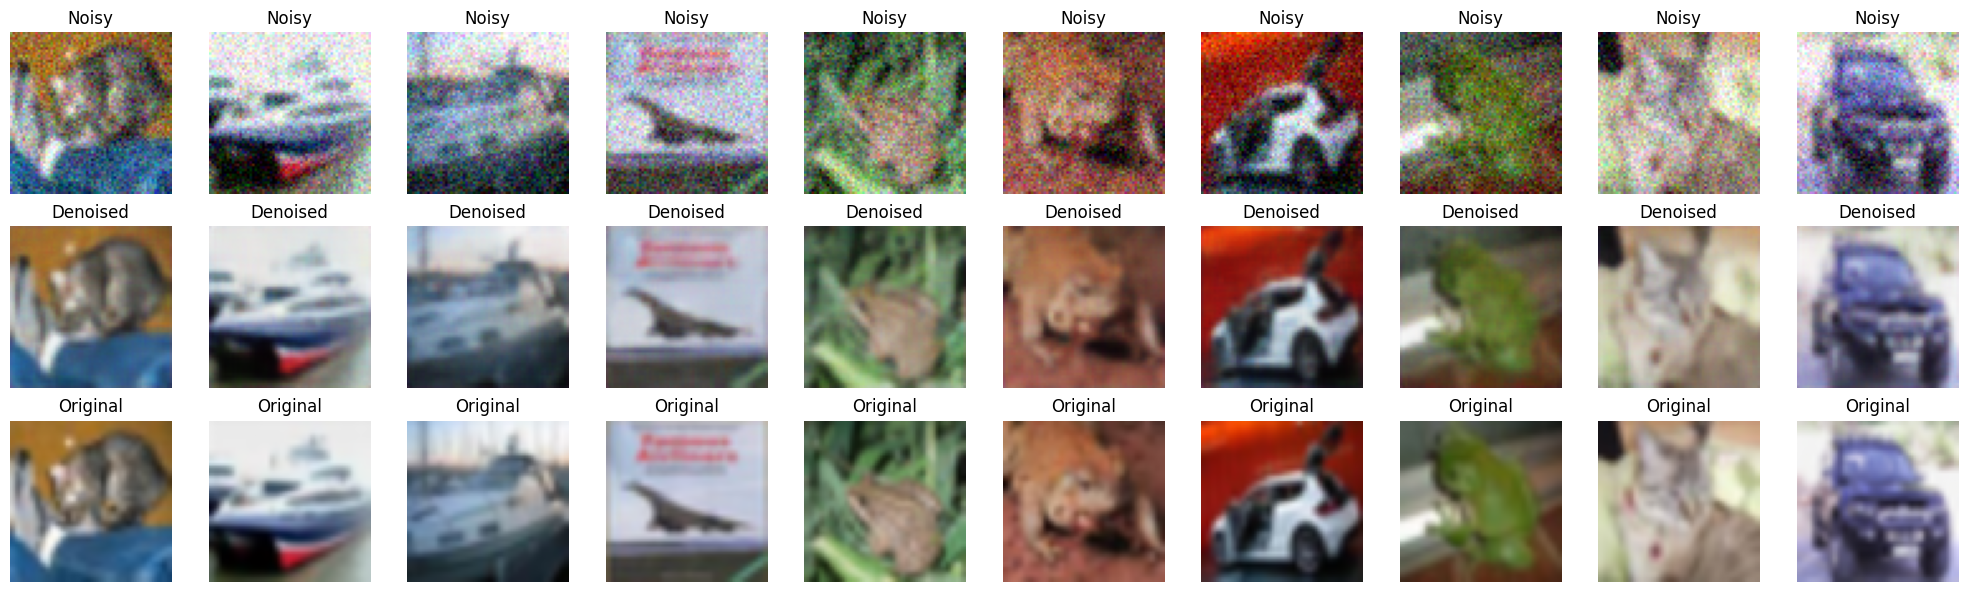

In [4]:
# Visualize results
n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    # Noisy image
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test_noisy[i])
    plt.title("Noisy")
    plt.axis("off")

    # Denoised output
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.title("Denoised")
    plt.axis("off")

    # Original clean image
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(x_test[i])
    plt.title("Original")
    plt.axis("off")

plt.tight_layout()
plt.show()